<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      1000 non-null   int64 
 1   Gender                   1000 non-null   object
 2   Cholesterol              1000 non-null   int64 
 3   Blood Pressure           1000 non-null   int64 
 4   Heart Rate               1000 non-null   int64 
 5   Smoking                  1000 non-null   object
 6   Alcohol Intake           660 non-null    object
 7   Exercise Hours           1000 non-null   int64 
 8   Family History           1000 non-null   object
 9   Diabetes                 1000 non-null   object
 10  Obesity                  1000 non-null   object
 11  Stress Level             1000 non-null   int64 
 12  Blood Sugar              1000 non-null   int64 
 13  Exercise Induced Angina  1000 non-null   object
 14  Chest Pain Type          1000 non-null   

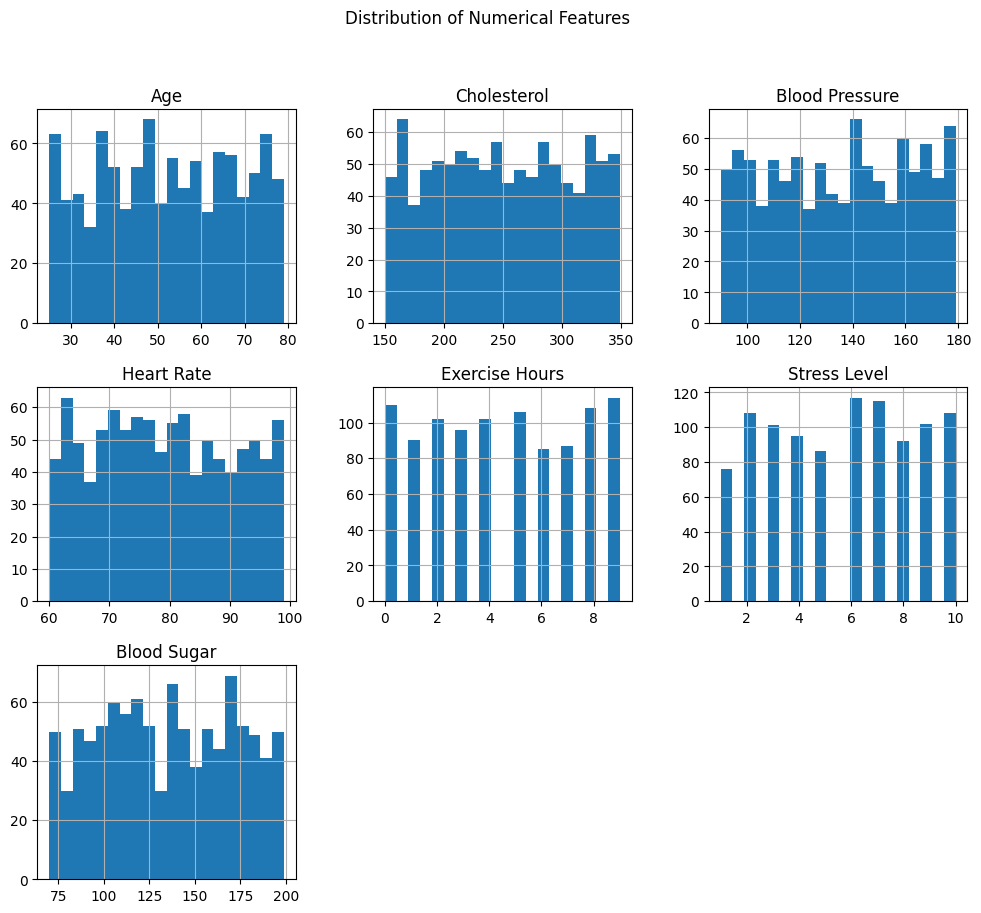

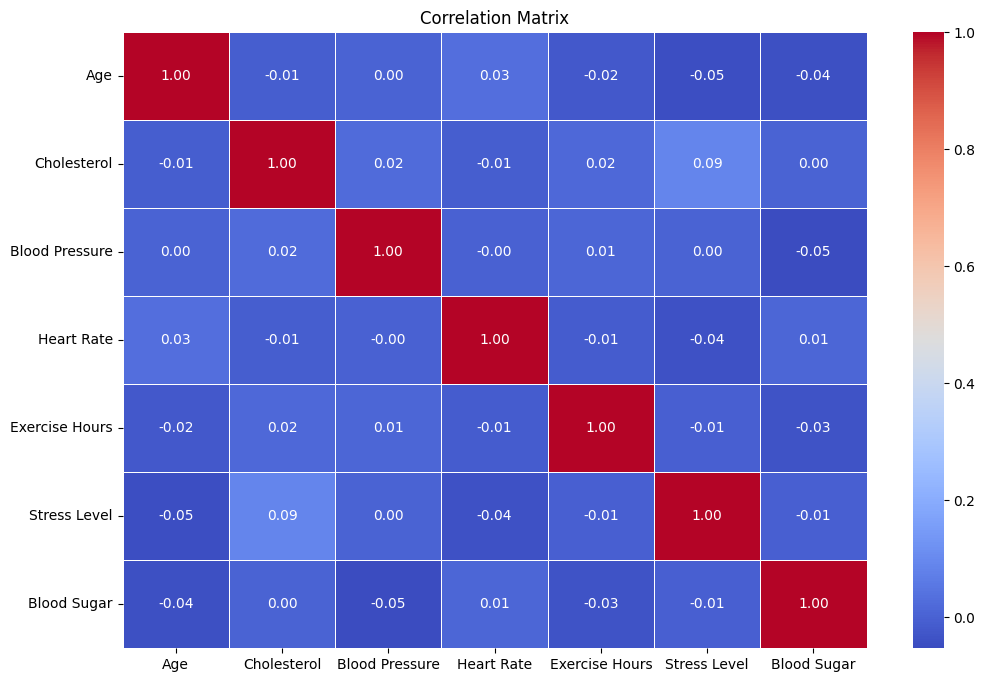

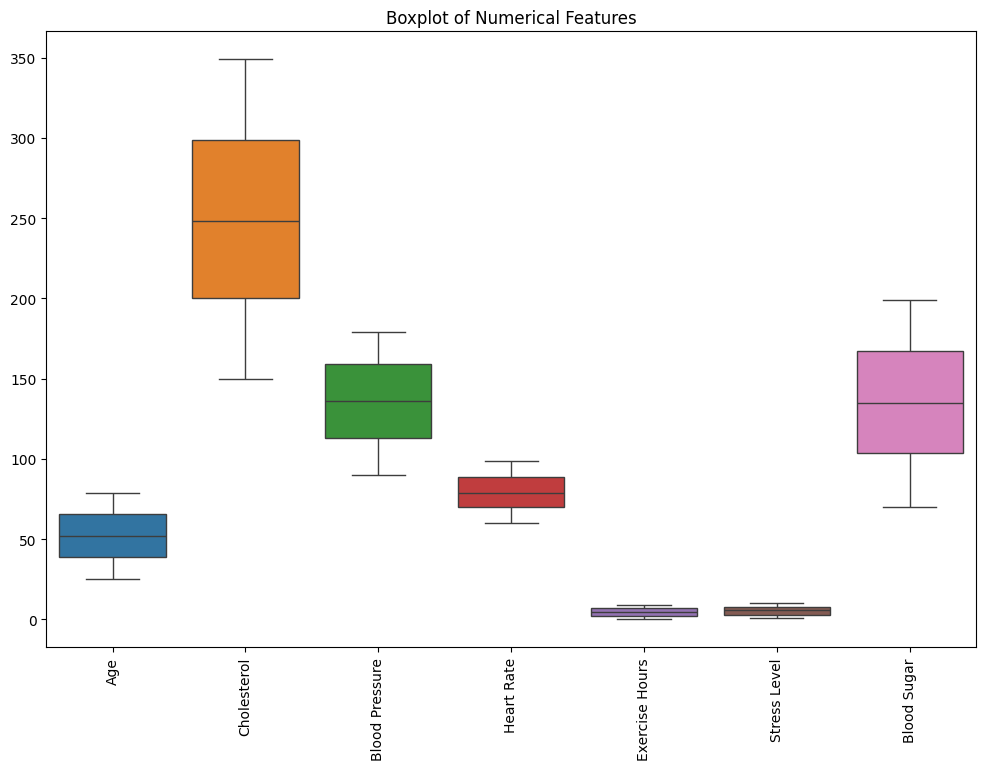

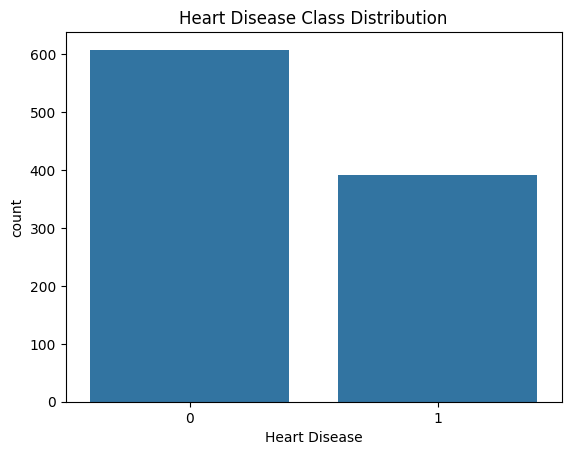

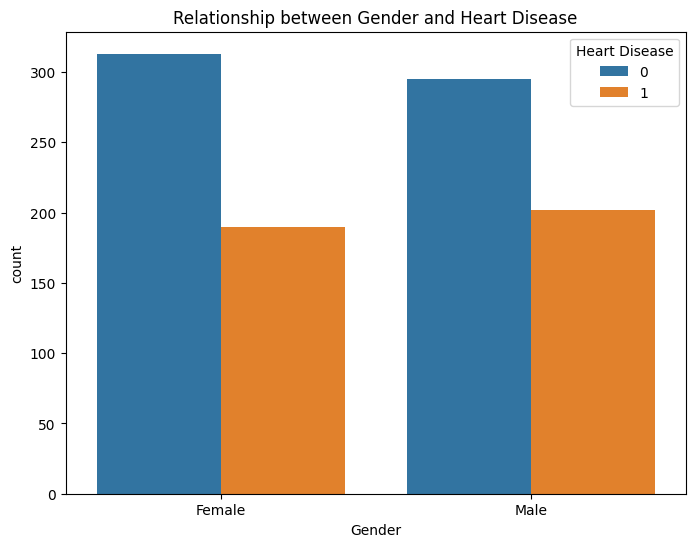

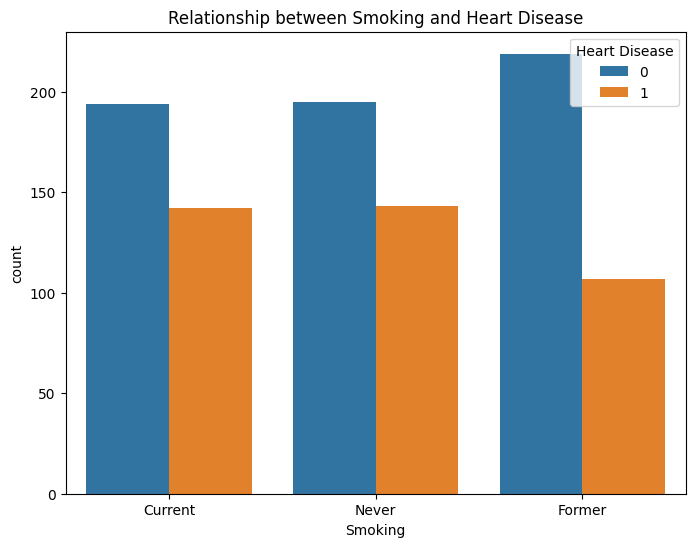

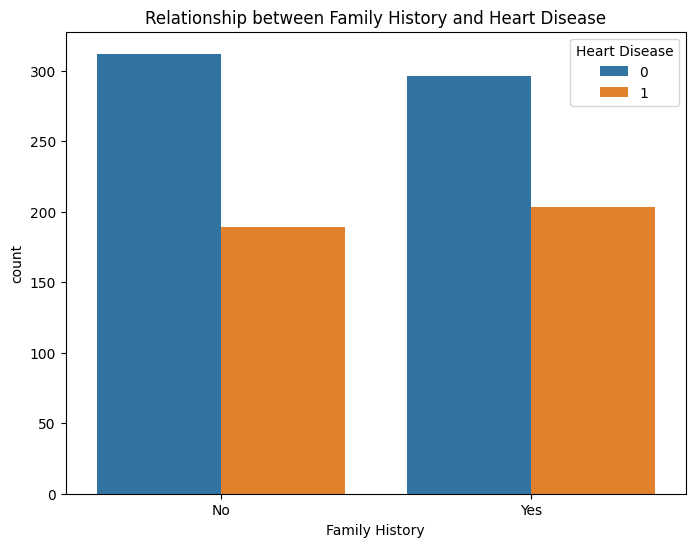

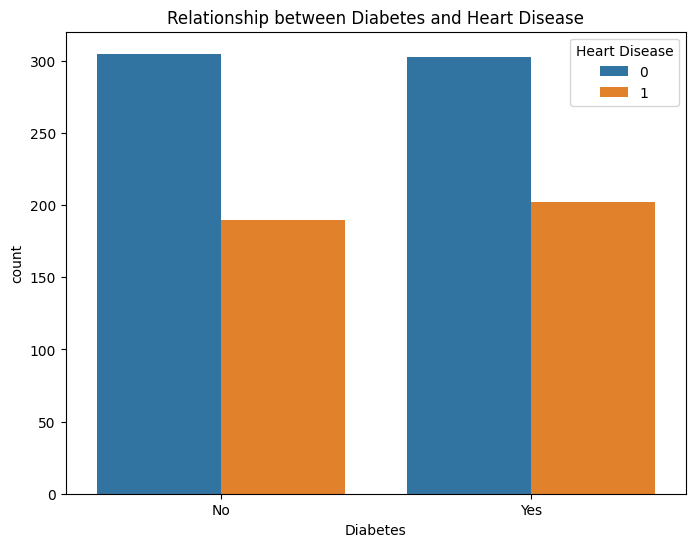

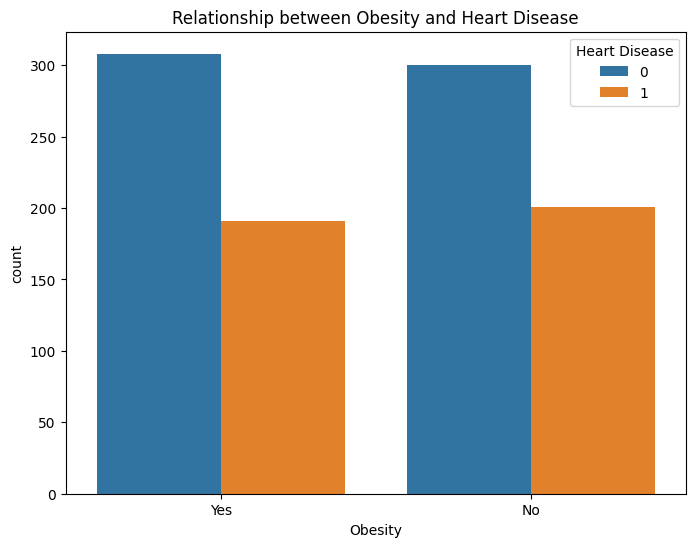

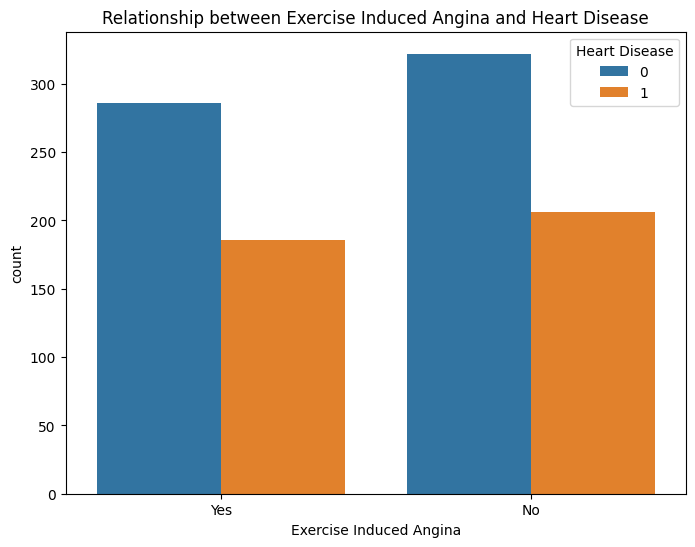

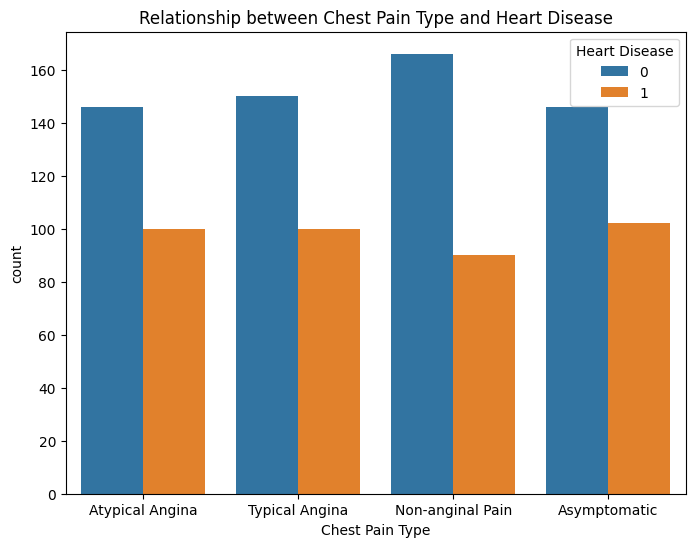

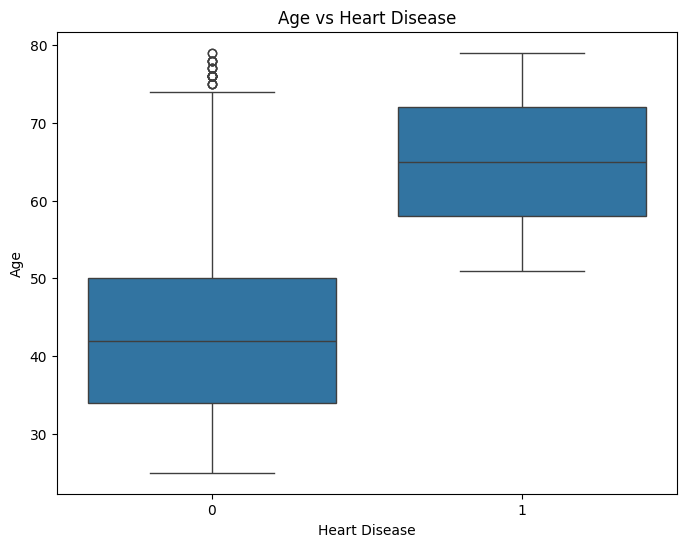

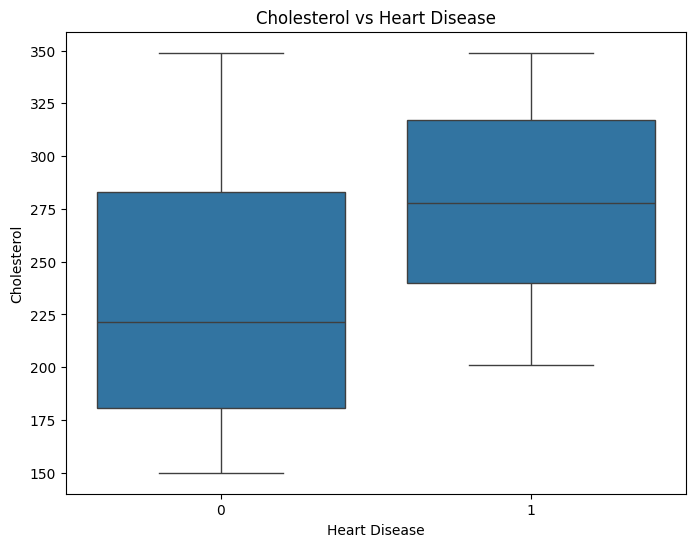

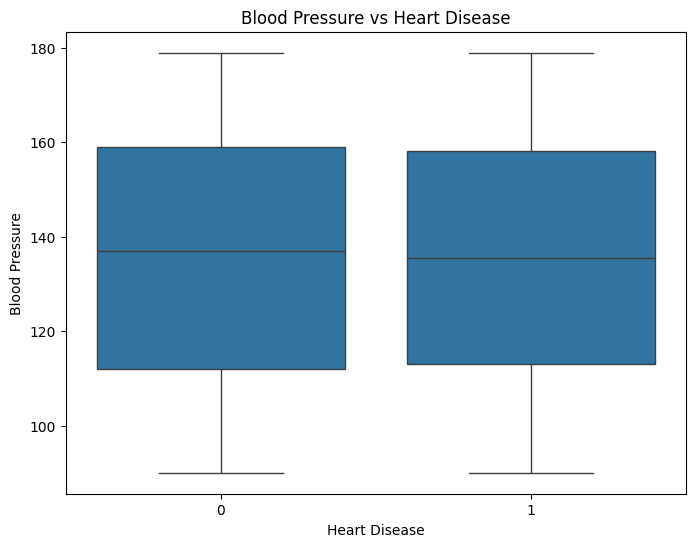

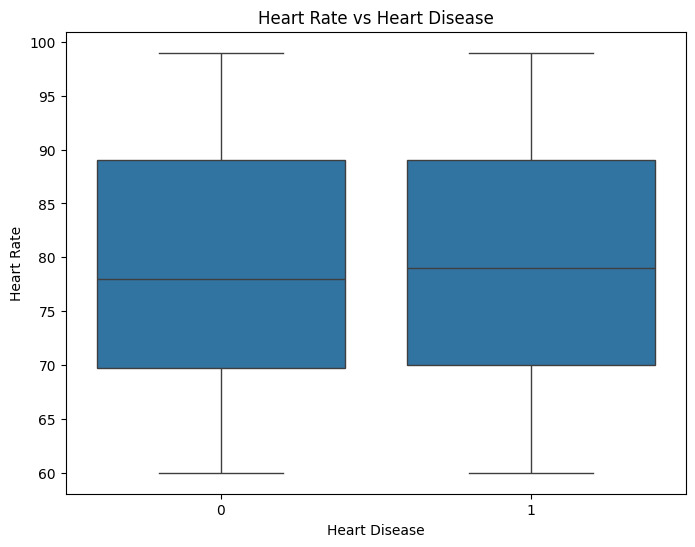

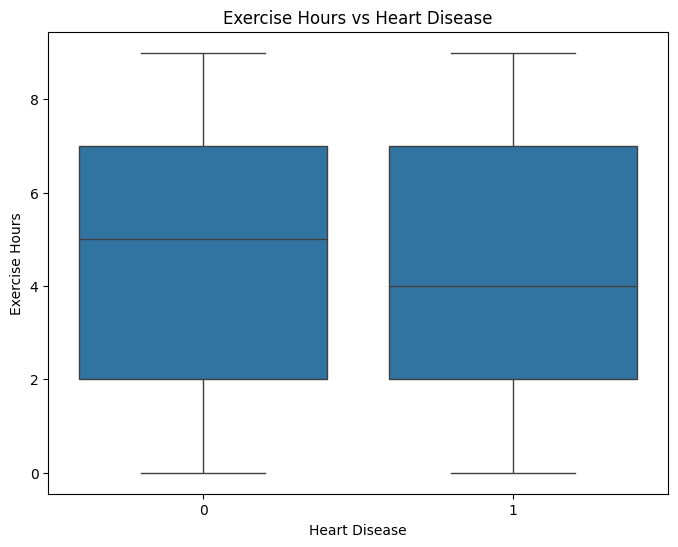

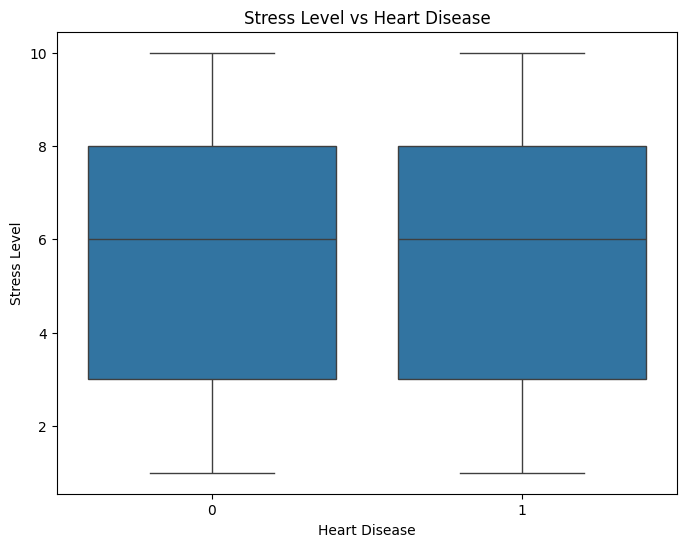

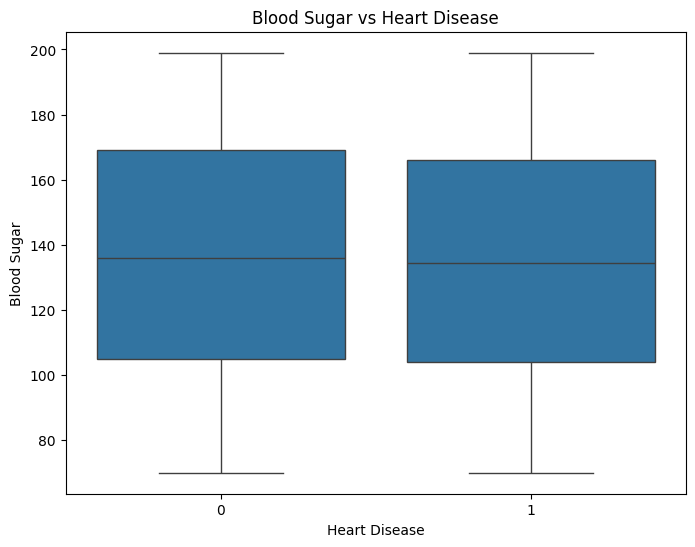

VarianceThreshold(threshold=0.01)
Age                                  247.342493
Cholesterol                         3354.109388
Blood Pressure                       696.342381
Heart Rate                           131.930314
Exercise Hours                         8.609769
Stress Level                           8.014699
Blood Sugar                         1346.862381
Gender_Male                            0.250241
Smoking_Former                         0.219944
Smoking_Never                          0.223980
Family History_Yes                     0.250249
Diabetes_Yes                           0.250225
Obesity_Yes                            0.250249
Exercise Induced Angina_Yes            0.249465
Chest Pain Type_Atypical Angina        0.185670
Chest Pain Type_Non-anginal Pain       0.190655
Chest Pain Type_Typical Angina         0.187688
dtype: float64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import joblib
sys.path.append("C:/Users/AARAV/OneDrive/Desktop/HealthMentor/backend")  # path where manage.py is

# Now try the import
from disease_prediction.ml.model import RandomForestClassifierScratch


# Dataset information
dataset=pd.read_csv('heart_disease_dataset.csv')
dataset.head()
dataset.info()
dataset.describe()
dataset.isnull().sum()#alcohol intake (1000-660) null
dataset.notnull().sum()#alcohol intake 660 not null
dataset[dataset.duplicated()]#no duplicate
dataset.dtypes#object and int64
dataset.columns#16 col ko name

for cols in dataset.columns:
  dataset[cols].unique()#all the unique values of each column especially for categorical feature
dataset['Heart Disease'].value_counts()#0 608 ota and 1 392 ota

# preprocessing dataset
dataset=dataset.drop(columns=["Alcohol Intake"])#almost 34% null value xa so let's remove

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# label_encoders = {}

categorical_columns = ['Gender', 'Smoking', 'Family History', 'Diabetes',
                       'Obesity', 'Exercise Induced Angina', 'Chest Pain Type']

# Separate numerical and categorical columns
numerical_columns = [col for col in dataset.columns
                     if col not in categorical_columns + ['Heart Disease']]
print(numerical_columns)

# Exploratory data analysis
# Plotting histograms for all numerical features
dataset[numerical_columns].hist(figsize=(12, 10), bins=20)
plt.suptitle("Distribution of Numerical Features")
plt.show()

# Correlation matrix of numerical features
corr_matrix = dataset[numerical_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Boxplot for detecting outliers in numerical features
plt.figure(figsize=(12, 8))
sns.boxplot(data=dataset[numerical_columns])
plt.title("Boxplot of Numerical Features")
plt.xticks(rotation=90)
plt.show()

# Class distribution of the target variable
sns.countplot(x='Heart Disease', data=dataset)
plt.title("Heart Disease Class Distribution")
plt.show()

# Visualize relationship between categorical features and target variable
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, hue='Heart Disease', data=dataset)
    plt.title(f"Relationship between {col} and Heart Disease")
    plt.show()

# Boxplot for numerical features with respect to target variable
for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Heart Disease', y=dataset[col], data=dataset)
    plt.title(f"{col} vs Heart Disease")
    plt.show()

# One-hot encode categorical data
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = pd.DataFrame(
    encoder.fit_transform(dataset[categorical_columns]).astype(int),
    columns=encoder.get_feature_names_out(categorical_columns)
)
joblib.dump(encoder, 'encoder.pkl')

# Split the dataset into features and target variable
X = pd.concat([dataset[numerical_columns].reset_index(drop=True),
               encoded_data.reset_index(drop=True)], axis=1)
y = dataset['Heart Disease']

# Removing low variance features. Almost sabai fetures ko variance is good so thresold 0.01 halda none will be removed.
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
print(selector)
X_selected = pd.DataFrame(selector.fit_transform(X),
                          columns=X.columns[selector.get_support()])
joblib.dump(selector, 'selector.pkl')
# variance of all the features
variance = X.var()
print(variance)

# Split the data into training and testing sets (80% train, 20% test).stratify preserve class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib

# 1. Initialize your custom Random Forest Classifier
rf_model = RandomForestClassifierScratch(
    n_estimators=100,
    max_depth=2,
    random_state=42,
    class_weight='balanced'
)

# 2. Fit the model
rf_model.fit(X_train.values, y_train.values)
joblib.dump(rf_model, 'rforest_model.pkl')


In [ ]:
# 3. Predict on test data
y_pred_scratch = rf_model.predict(X_test.values)

# 4. Evaluation Metrics
print("Accuracy:", accuracy_score(y_test, y_pred_scratch))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_scratch, target_names=['No Disease', 'Disease']))

# 5. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_scratch)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 6. ROC Curve and AUC Score
y_proba_scratch = rf_model.predict_proba(X_test.values)[:, 1]  # Probabilities for class 1

fpr, tpr, thresholds = roc_curve(y_test, y_proba_scratch)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Custom RF (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
print(f"AUC Score: {roc_auc:.4f}")

# 7. Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_scratch)
avg_precision = average_precision_score(y_test, y_proba_scratch)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()
print(f"Average Precision Score: {avg_precision:.4f}")

# 8. Error Analysis
misclassified = X_test[y_test != y_pred_scratch]
misclassified_labels = y_test[y_test != y_pred_scratch]
misclassified_preds = y_pred_scratch[y_test != y_pred_scratch]

misclassified_df = misclassified.copy()
misclassified_df['True Label'] = misclassified_labels
misclassified_df['Predicted Label'] = misclassified_preds
print(f"Number of misclassified samples: {len(misclassified_df)}")
print(misclassified_df.head())

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import joblib
sys.path.append("C:/Users/AARAV/OneDrive/Desktop/HealthMentor/backend") 

from disease_prediction.ml.model import RandomForestClassifierScratch

dataset=pd.read_csv('heart_disease_dataset.csv')
dataset.head()
dataset.info()
dataset.describe()
dataset.isnull().sum()
dataset.notnull().sum()
dataset[dataset.duplicated()]
dataset.dtypes
dataset.columns

for cols in dataset.columns:
  dataset[cols].unique()
dataset['Heart Disease'].value_counts()

dataset=dataset.drop(columns=["Alcohol Intake"])

from sklearn.model_selection import train_test_split
categorical_columns = ['Gender', 'Smoking', 'Family History', 'Diabetes',
                       'Obesity', 'Exercise Induced Angina', 'Chest Pain Type']

numerical_columns = [col for col in dataset.columns
                     if col not in categorical_columns + ['Heart Disease']]
print(numerical_columns)

dataset[numerical_columns].hist(figsize=(12, 10), bins=20)
plt.suptitle("Distribution of Numerical Features")
plt.show()

corr_matrix = dataset[numerical_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=dataset[numerical_columns])
plt.title("Boxplot of Numerical Features")
plt.xticks(rotation=90)
plt.show()

sns.countplot(x='Heart Disease', data=dataset)
plt.title("Heart Disease Class Distribution")
plt.show()

for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, hue='Heart Disease', data=dataset)
    plt.title(f"Relationship between {col} and Heart Disease")
    plt.show()

for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Heart Disease', y=dataset[col], data=dataset)
    plt.title(f"{col} vs Heart Disease")
    plt.show()

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = pd.DataFrame(
    encoder.fit_transform(dataset[categorical_columns]).astype(int),
    columns=encoder.get_feature_names_out(categorical_columns)
)
joblib.dump(encoder, 'encoder.pkl')

X = pd.concat([dataset[numerical_columns].reset_index(drop=True),
               encoded_data.reset_index(drop=True)], axis=1)
y = dataset['Heart Disease']

from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
print(selector)
X_selected = pd.DataFrame(selector.fit_transform(X),
                          columns=X.columns[selector.get_support()])
joblib.dump(selector, 'selector.pkl')
variance = X.var()
print(variance)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib

rf_model = RandomForestClassifierScratch(
    n_estimators=100,
    max_depth=2,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train.values, y_train.values)
joblib.dump(rf_model, 'rforest_model.pkl')

y_pred_scratch = rf_model.predict(X_test.values)

print("Accuracy:", accuracy_score(y_test, y_pred_scratch))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_scratch, target_names=['No Disease', 'Disease']))

conf_matrix = confusion_matrix(y_test, y_pred_scratch)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 6. ROC Curve and AUC Score
y_proba_scratch = rf_model.predict_proba(X_test.values)[:, 1]  # Probabilities for class 1

fpr, tpr, thresholds = roc_curve(y_test, y_proba_scratch)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Custom RF (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
print(f"AUC Score: {roc_auc:.4f}")

# 7. Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_scratch)
avg_precision = average_precision_score(y_test, y_proba_scratch)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()
print(f"Average Precision Score: {avg_precision:.4f}")

# 8. Error Analysis
misclassified = X_test[y_test != y_pred_scratch]
misclassified_labels = y_test[y_test != y_pred_scratch]
misclassified_preds = y_pred_scratch[y_test != y_pred_scratch]

misclassified_df = misclassified.copy()
misclassified_df['True Label'] = misclassified_labels
misclassified_df['Predicted Label'] = misclassified_preds
print(f"Number of misclassified samples: {len(misclassified_df)}")
print(misclassified_df.head())

